In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import math
import torch
import matplotlib.pyplot as plt

# install instructions here https://github.com/nicola-decao/power_spherical
from power_spherical import PowerSpherical

In [3]:
torch.manual_seed(0)

In [4]:
# here we create a PowerSpherical distribution with n_clusters locations around the unit circle
# see here for more info (https://arxiv.org/abs/2006.04437). TLDR: the PowerSpherical distribution 
# needs a directiona and a scale parameter and it has support on the n-sphere
n_clusters = 6

dist = PowerSpherical(
    loc=torch.tensor([
      [
          math.cos(2 * torch.pi * i / n_clusters),
          math.sin(2 * torch.pi * i / n_clusters)
      ]
      for i in range(n_clusters)
    ]),
    scale=torch.tensor([500. for _ in range(n_clusters)]),
)

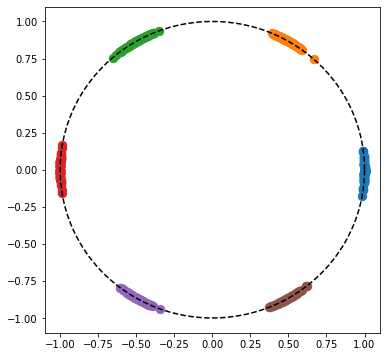

In [5]:
# here we sample from the distributions and we plot it
plt.figure(figsize=(6, 6))
t = torch.linspace(0, 2 * torch.pi, 1000)
plt.plot(torch.cos(t), torch.sin(t), "--", color="black")

n_samples = 100
samples = dist.sample((n_samples,))
for e in samples.transpose(0, 1):
    plt.scatter(*e.T, s=70)
plt.show()

In [6]:
# creates a random projection of dimensionality dim and adds gaussian noise
def random_proj(x, dim=10, noise=0.05):
    with torch.no_grad():
        return torch.nn.Linear(2, dim, bias=False)(x) + torch.randn(x.shape[:-1] + (dim,)) * noise

projected_samples = random_proj(samples).flatten(0, 1)

In [7]:
# lets how well we can reconstruct with k_components
svd = projected_samples.svd()
k_components = 2
svd.U * (svd.S * (svd.S >= svd.S.topk(k_components).values[-1]).float()) @ svd.V.T, projected_samples

(tensor([[ 0.4308,  0.6717, -0.6460,  ...,  0.4839,  0.2611, -0.3502],
         [ 0.3143,  0.5998,  0.1825,  ...,  0.3061,  0.1849, -0.3847],
         [-0.1196, -0.0857,  0.7788,  ..., -0.1773, -0.0776, -0.0213],
         ...,
         [-0.4452, -0.6922,  0.6790,  ..., -0.5009, -0.2699,  0.3596],
         [-0.3327, -0.6543, -0.3084,  ..., -0.3158, -0.1947,  0.4301],
         [ 0.1174,  0.0673, -0.8649,  ...,  0.1813,  0.0771,  0.0408]]),
 tensor([[ 0.5046,  0.6567, -0.6349,  ...,  0.4469,  0.1977, -0.3611],
         [ 0.3248,  0.6215,  0.1680,  ...,  0.2421,  0.0927, -0.3837],
         [-0.1019, -0.1657,  0.7891,  ..., -0.1828, -0.0390, -0.0821],
         ...,
         [-0.4901, -0.6350,  0.6834,  ..., -0.5396, -0.2724,  0.3950],
         [-0.3314, -0.5855, -0.2848,  ..., -0.3207, -0.2786,  0.4461],
         [ 0.1021,  0.1009, -0.8449,  ...,  0.1392,  0.0632,  0.1405]]))

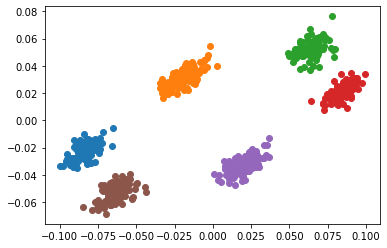

In [10]:
# let's plot PCA with 2 dim. since the original dimensionality of the data is 2 we can notice that 
# clusters appear very clearly and they are also separable
for e in projected_samples.view(n_samples, n_clusters, -1).transpose(0, 1):
    plt.scatter(*(e @ svd.U[:2].T).T)
plt.show()

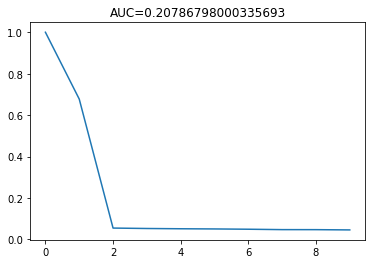

In [9]:
# AUC plot
normalized_eigenvalues = svd.S / svd.S.max()
plt.title(f"AUC={normalized_eigenvalues.mean()}")
plt.plot(normalized_eigenvalues)
plt.show()